### GPU kullanımı için gerekli izinlerin alınması

In [ ]:
from google.colab import drive
drive.mount('/gdrive')
%cd /gdrive

Mounted at /gdrive
/gdrive


**Bulunduğumuz konumu çalışacağımız verilerin bulunduğu klasör ile değiştirme**

In [26]:
import os
os.chdir('/gdrive/My Drive/Covid-19-Xray/data')

###Gerekli Kütüphaneler ve Framework'ler

In [27]:
import os
import warnings
import pickle
import tensorflow
from tensorflow.keras import Input
from tensorflow.keras.utils import plot_model
from tensorflow.keras import layers
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tensorflow.keras.layers import Dense, Activation, Dropout, Flatten, Conv2D, MaxPooling2D, GlobalAveragePooling2D, GlobalMaxPooling2D, BatchNormalization
from tensorflow.keras.callbacks import ReduceLROnPlateau, ModelCheckpoint, EarlyStopping, CSVLogger
from sklearn.metrics import accuracy_score, balanced_accuracy_score, f1_score, confusion_matrix, recall_score, cohen_kappa_score, precision_score
from sklearn import metrics
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
from sklearn.model_selection import train_test_split
from itertools import cycle
from tensorflow.python.keras.engine.functional import Functional
from sklearn.utils import shuffle
from tensorflow.keras.layers import Dense, Conv2D, MaxPooling2D, Flatten, BatchNormalization, Dropout, Activation
from tensorflow.keras.activations import relu, softmax
from tensorflow.keras.applications import ResNet50, InceptionResNetV2, DenseNet169, VGG19
from tensorflow.keras.optimizers import Adam, Adamax, RMSprop, SGD, Nadam, Adadelta, Adagrad, Ftrl
from tensorflow.keras.losses import SparseCategoricalCrossentropy

### Verilerin Yüklenmesi

In [28]:
X_ = open('X.pickle', 'rb')
y_ = open('y.pickle', 'rb')

X = pickle.load(X_)
y = pickle.load(y_)
X_.close()
y_.close()

**Shuffle**

In [29]:
X, y = shuffle(X, y, random_state=0)
X = np.asarray(X)
y = np.asarray(y)

In [30]:
X[16].shape

(224, 224, 3)

### Train-Test Bölünmesi

In [31]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.15, random_state=0)

**Bulunduğumuz konumu(data klasörü) sonuçları kaydedeceğimiz konum ile değiştirme**

In [32]:
os.chdir('/gdrive/My Drive/Covid-19-Xray/saved_models')

# **Denenecekler Kısmı**

In [33]:
epochs = 50           # Epoch sayısı
batch_size = 8       # Batch size        # 32, 16, 8
optimizer = Adamax()    # Optimizer         # Adamax, RMSprop, SGD, Nadam, Adadelta, Adagrad, Ftrl

### **Functions**

**Accuracy-Loss Plots**

In [34]:
def plot_acc_loss_eng(history):
  plt.style.use("seaborn-darkgrid")
  train_loss = history.history['loss']
  val_loss = history.history['val_loss']
  train_acc = history.history['acc']
  val_acc = history.history['val_acc']
  xc = range(epochs)

  plt.figure(1, figsize=(7,5))
  plt.plot(xc, train_loss)
  plt.plot(xc, val_loss)
  plt.xlabel('num of Epochs')
  plt.ylabel('loss')
  plt.title('train_loss vs val_loss')
  plt.grid(True)
  plt.legend(['train','val'])

  plt.figure(2, figsize=(7,5))
  plt.plot(xc, train_acc)
  plt.plot(xc, val_acc)
  plt.xlabel('num of Epochs')
  plt.ylabel('accuracy')
  plt.title('train_acc vs val_acc')
  plt.grid(True)
  plt.legend(['train','val'], loc = 4)
  plt.style.use("seaborn-darkgrid")

  plt.show()

In [35]:
def plot_acc_loss_tr(history):
  plt.style.use("seaborn-darkgrid")
  train_loss = history.history['loss']
  val_loss = history.history['val_loss']
  train_acc = history.history['acc']
  val_acc = history.history['val_acc']
  xc = range(epochs)

  plt.figure(1, figsize=(7,5))
  plt.plot(xc, train_loss)
  plt.plot(xc, val_loss)
  plt.xlabel('Devir Sayısı')
  plt.ylabel('Kayıp')
  plt.title('Eğitim ve Test Hatası')
  plt.grid(True)
  plt.legend(['Eğitim','Doğrulama'])

  plt.figure(2, figsize=(7,5))
  plt.plot(xc, train_acc)
  plt.plot(xc, val_acc)
  plt.xlabel('Devir Sayısı')
  plt.ylabel('Başarım')
  plt.title('Eğitim ve Test Başarımı')
  plt.grid(True)
  plt.legend(['Eğitim', 'Doğrulama'], loc = 4)
  plt.style.use("seaborn-darkgrid")

  plt.show()

**Measurement Metrics**

In [36]:
def metric(X_test, y_test, model, model_name:str):
  warnings.filterwarnings("ignore")
  y_pred = model.predict(X_test)
  y_pred = np.argmax(y_pred, axis=1)

  print('\n\n{}  Model Accuracy Score:  {}'.format(model_name,  accuracy_score(y_test, y_pred)))
  print('\n\n{}  Model Balanced Accuracy Score: {} '.format(model_name, balanced_accuracy_score(y_test, y_pred)))
  print('\n\n{}  Model F1 Score: {} '.format(model_name, f1_score(y_test, y_pred, pos_label='positive', average='micro')))
  print('\n\n{}  Model Precision Score: {} '.format(model_name, precision_score(y_test, y_pred, pos_label='positive', average='micro')))
  print('\n\n{}  Model Cohen Kappa Score: {} '.format(model_name, cohen_kappa_score(y_test, y_pred)))
  print('\n\n{}  Model Recall Score: {} '.format(model_name, recall_score(y_test, y_pred, pos_label='positive', average='micro')))

In [37]:
X_test[16].shape

(224, 224, 3)

**Confusion Matrix**

In [38]:
def cm_eng(X_test, y_test, model:Functional):
  y_pred = model.predict(X_test)
  y_pred = np.argmax(y_pred, axis=1)
  cm = confusion_matrix(y_test, y_pred)
  df_cm = pd.DataFrame(cm, columns=["Covid", "Normal", "Viral Pneumonia"], index=["Covid", "Normal", "Viral Pneumonia"])
  plt.figure(figsize=(8, 6), dpi=100)
  sns.heatmap(df_cm, annot=True, cmap='Blues', fmt='g');

In [39]:
def cm_tr(X_test, y_test, model:Functional):
  y_pred = model.predict(X_test)
  y_pred = np.argmax(y_pred, axis=1)
  cm = confusion_matrix(y_test, y_pred)
  df_cm = pd.DataFrame(cm, columns=["Covid", "Normal", "Viral Zatürre"], index=["Covid", "Normal", "Viral Zatürre"])
  plt.figure(figsize=(8, 6), dpi=100)
  sns.heatmap(df_cm, annot=True, cmap='Blues', fmt='g');

**Roc Curve**

In [40]:
def plot_roc_curve_eng(X_test, y_test, model):
  y_pred = model.predict(X_test)
  y_pred = np.argmax(y_pred, axis=1)
  plt.style.use("seaborn-darkgrid")
  target_test_roc = label_binarize(y_test, classes=[0, 1, 2])
  target_pred_roc = label_binarize(y_pred, classes=[0, 1, 2])
  n_classes = target_test_roc.shape[1]
  lw = 2

  fpr = dict()
  tpr = dict()
  roc_auc = dict()
  for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(target_test_roc[:,i], target_pred_roc[:,i])
    roc_auc[i] = auc(fpr[i], tpr[i])


  plt.figure(dpi=100)
  colors = cycle(['purple', 'lime', 'blue'])
  for i, color in zip(range(n_classes), colors):
      plt.plot(fpr[i], tpr[i], color=color, lw=lw,
              label='ROC Curve of Class {0} (Area = {1:0.2f})'
              ''.format(i, roc_auc[i]))

  plt.plot([0, 1], [0, 1], 'k--', lw=lw, linestyle='--')
  plt.xlim([-0.01, 1.0])
  plt.ylim([-0.05, 1.05])
  plt.xlabel('False Positive Rate')
  plt.ylabel('True Positive Rate')
  plt.title('Receiver operating characteristic to multi-class')
  plt.legend(loc="best")
  plt.show()

In [41]:
def plot_roc_curve_tr(X_test, y_test, model):
  y_pred = model.predict(X_test)
  y_pred = np.argmax(y_pred, axis=1)
  plt.style.use("seaborn-darkgrid")
  target_test_roc = label_binarize(y_test, classes=[0, 1, 2])
  target_pred_roc = label_binarize(y_pred, classes=[0, 1, 2])
  n_classes = target_test_roc.shape[1]
  lw = 2

  fpr = dict()
  tpr = dict()
  roc_auc = dict()
  for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(target_test_roc[:,i], target_pred_roc[:,i])
    roc_auc[i] = auc(fpr[i], tpr[i])


  plt.figure(dpi=100)
  colors = cycle(['purple', 'lime', 'blue'])
  for i, color in zip(range(n_classes), colors):
      plt.plot(fpr[i], tpr[i], color=color, lw=lw,
              label='{0} Sınıfının ROC Eğrisi (Bölge = {1:0.2f})'
              ''.format(i, roc_auc[i]))

  plt.plot([0, 1], [0, 1], 'k--', lw=lw, linestyle='--')
  plt.xlim([-0.01, 1.0])
  plt.ylim([-0.05, 1.05])
  plt.xlabel('Yanlış Pozitif Oranı')
  plt.ylabel('Doğru Pozitif Oranı')
  plt.title('Alıcı İşletim Karakteristiği')
  plt.legend(loc="best")
  plt.show()

## **ResNet50**

In [42]:
resnet50 = ResNet50(include_top=False, weights='imagenet', input_shape=(224, 224, 3))
resnet50.trainable=False

94773248/94765736 [==============================] - 2s 0us/step


In [43]:
inputs = tensorflow.keras.Input(shape=(224, 224, 3))
x = resnet50(inputs, training = True)

avg = GlobalAveragePooling2D()(x)

flat = Flatten()(avg)

batch = BatchNormalization()(flat)
drop = Dropout(0.25)(batch)
dense = Dense(512, activation='relu')(drop)
batch_2 = BatchNormalization()(dense)
drop_2 = Dropout(0.5)(batch_2)
outputs = tensorflow.keras.layers.Dense(3, activation=softmax)(drop_2)
model = tensorflow.keras.Model(inputs, outputs)
model.compile(optimizer=optimizer, loss=SparseCategoricalCrossentropy(), metrics='acc')
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
resnet50 (Functional)        (None, 7, 7, 2048)        23587712  
_________________________________________________________________
global_average_pooling2d (Gl (None, 2048)              0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 2048)              0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 2048)              8192      
_________________________________________________________________
dropout_1 (Dropout)          (None, 2048)              0         
_________________________________________________________________
dense_2 (Dense)              (None, 512)               104908

#### **Train**

In [45]:
callback_list = [
                 ReduceLROnPlateau(monitor="val_loss", factor = 0.1, patience=5),
                 CSVLogger('resnet_50.csv', append=True, separator=';'),
                 ModelCheckpoint(filepath='resnet_50.h5', monitor='val_loss', mode='min',verbose=1, save_best_only=True)
]

history = model.fit(X_train, y_train,
                    epochs=epochs,
                    validation_split=.15,
                    batch_size=batch_size, 
                    callbacks=callback_list)

Epoch 1/50
351/351 [==============================] - 36s 90ms/step - loss: 0.4966 - acc: 0.8660 - val_loss: 0.1044 - val_acc: 0.9637

Epoch 00001: val_loss improved from inf to 0.10438, saving model to resnet_50.h5
Epoch 2/50
351/351 [==============================] - 30s 85ms/step - loss: 0.2531 - acc: 0.9085 - val_loss: 0.0772 - val_acc: 0.9698

Epoch 00002: val_loss improved from 0.10438 to 0.07724, saving model to resnet_50.h5
Epoch 3/50
351/351 [==============================] - 30s 86ms/step - loss: 0.2024 - acc: 0.9284 - val_loss: 0.0646 - val_acc: 0.9758

Epoch 00003: val_loss improved from 0.07724 to 0.06463, saving model to resnet_50.h5
Epoch 4/50
351/351 [==============================] - 30s 86ms/step - loss: 0.1688 - acc: 0.9463 - val_loss: 0.0625 - val_acc: 0.9758

Epoch 00004: val_loss improved from 0.06463 to 0.06253, saving model to resnet_50.h5
Epoch 5/50
351/351 [==============================] - 30s 86ms/step - loss: 0.1711 - acc: 0.9408 - val_loss: 0.0616 - val_ac

#### **Plot Acc - Loss**

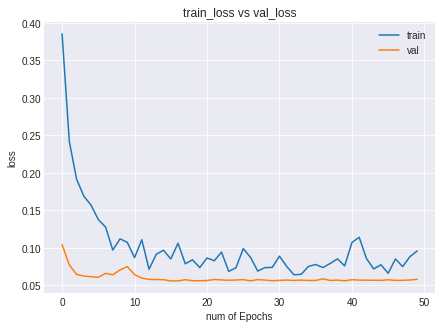

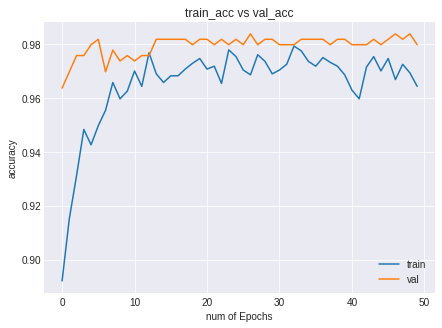

In [46]:
plot_acc_loss_eng(history)

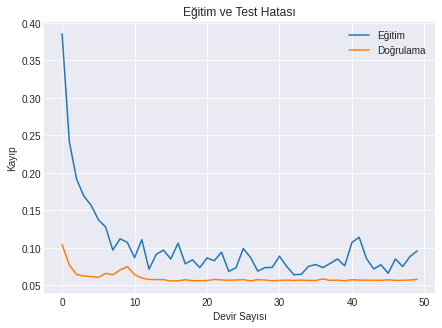

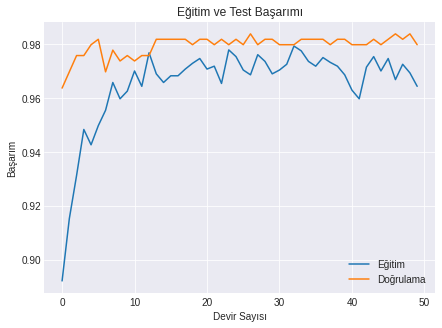

In [47]:
plot_acc_loss_tr(history)

#### **Metrics Results**

In [48]:
metric(X_test, y_test, model, model_name='ResNet50')



ResNet50  Model Accuracy Score:  0.9794168096054888


ResNet50  Model Balanced Accuracy Score: 0.9797105823565907 


ResNet50  Model F1 Score: 0.9794168096054888 


ResNet50  Model Precision Score: 0.9794168096054888 


ResNet50  Model Cohen Kappa Score: 0.9690847385724891 


ResNet50  Model Recall Score: 0.9794168096054888 


In [49]:
model.evaluate(X_test, y_test)

19/19 [==============================] - 5s 195ms/step - loss: 0.0597 - acc: 0.9794


[0.05971040949225426, 0.9794167876243591]

#### **Confusion Matrix**

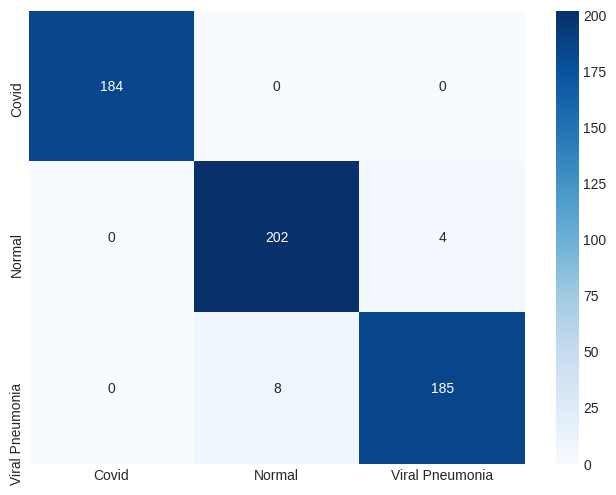

In [50]:
cm_eng(X_test, y_test, model)

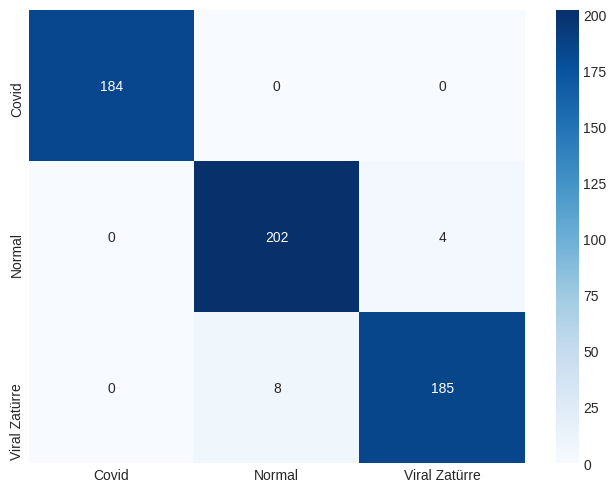

In [51]:
cm_tr(X_test, y_test, model)

#### **Roc Curve**

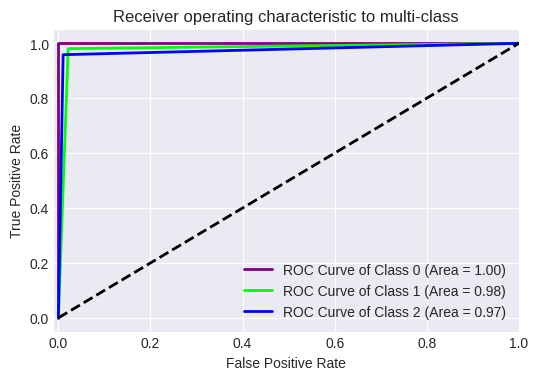

In [52]:
plot_roc_curve_eng(X_test, y_test, model)

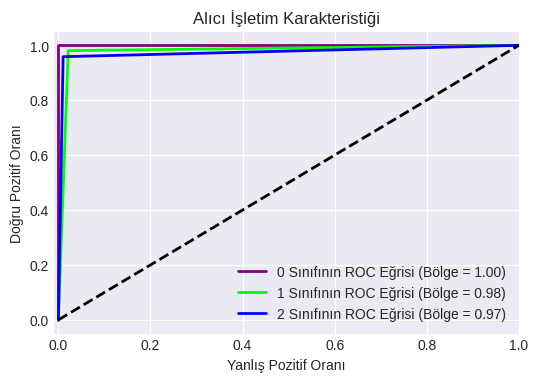

In [53]:
plot_roc_curve_tr(X_test, y_test, model)

## **InceptionResNetV2**

In [ ]:
inceptionResnetv2 = InceptionResNetV2(include_top=False, weights='imagenet', input_shape=(224, 224, 3))
inceptionResnetv2.trainable=False

In [ ]:
inputs = tensorflow.keras.Input(shape=(224, 224, 3))
x = inceptionResnetv2(inputs, training = True)

avg = GlobalAveragePooling2D()(x)

flat = Flatten()(avg)

batch = BatchNormalization()(flat)
drop = Dropout(0.25)(batch)
dense = Dense(512, activation='relu')(drop)
batch_2 = BatchNormalization()(dense)
drop_2 = Dropout(0.5)(batch_2)
outputs = tensorflow.keras.layers.Dense(3, activation=softmax)(drop_2)
model = tensorflow.keras.Model(inputs, outputs)
model.compile(optimizer=optimizer, loss=SparseCategoricalCrossentropy(), metrics='acc')
model.summary()

Model: "model_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_12 (InputLayer)        [(None, 224, 224, 3)]     0         
_________________________________________________________________
inception_resnet_v2 (Functio (None, 5, 5, 1536)        54336736  
_________________________________________________________________
global_average_pooling2d_5 ( (None, 1536)              0         
_________________________________________________________________
flatten_5 (Flatten)          (None, 1536)              0         
_________________________________________________________________
batch_normalization_416 (Bat (None, 1536)              6144      
_________________________________________________________________
dropout_10 (Dropout)         (None, 1536)              0         
_________________________________________________________________
dense_10 (Dense)             (None, 512)               7869

#### **Train**

In [ ]:
callback_list = [
                 ReduceLROnPlateau(monitor="val_loss", factor = 0.1, patience=5),
                 CSVLogger('inceptionResnet_v2.csv', append=True, separator=';'),
                 ModelCheckpoint(filepath='inceptionResnet_v2.h5', monitor='val_loss', mode='min',verbose=1, save_best_only=True)
]

history = model.fit(X_train, y_train,
                    epochs=epochs,
                    validation_split=.15,
                    batch_size=batch_size, 
                    callbacks=callback_list)

Epoch 1/30
44/44 [==============================] - 20s 268ms/step - loss: 2.6453 - acc: 0.2095 - val_loss: 4.3116 - val_acc: 0.3306

Epoch 00001: val_loss improved from inf to 4.31156, saving model to inceptionResnet_v2.h5
Epoch 2/30
44/44 [==============================] - 9s 210ms/step - loss: 2.6036 - acc: 0.2100 - val_loss: 2.8503 - val_acc: 0.1190

Epoch 00002: val_loss improved from 4.31156 to 2.85026, saving model to inceptionResnet_v2.h5
Epoch 3/30
44/44 [==============================] - 9s 210ms/step - loss: 2.5632 - acc: 0.2207 - val_loss: 2.3679 - val_acc: 0.1089

Epoch 00003: val_loss improved from 2.85026 to 2.36792, saving model to inceptionResnet_v2.h5
Epoch 4/30
44/44 [==============================] - 9s 209ms/step - loss: 2.6230 - acc: 0.2097 - val_loss: 2.1969 - val_acc: 0.1089

Epoch 00004: val_loss improved from 2.36792 to 2.19693, saving model to inceptionResnet_v2.h5
Epoch 5/30
44/44 [==============================] - 9s 209ms/step - loss: 2.4980 - acc: 0.2371 

#### **Plot Acc - Loss**

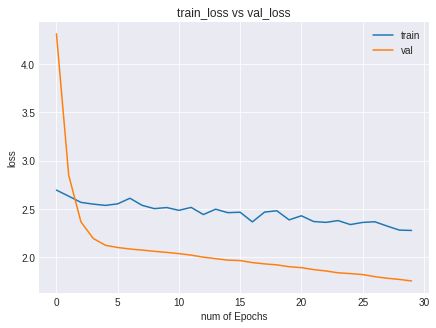

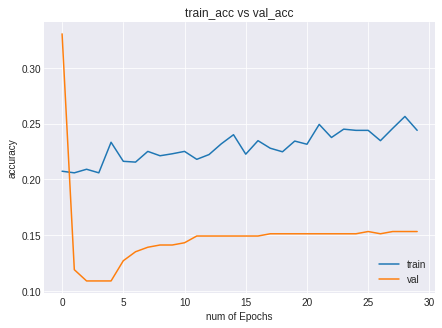

In [ ]:
plot_acc_loss_eng(history)

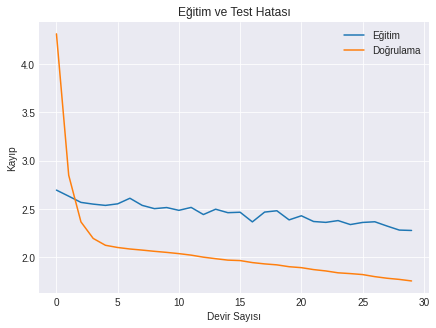

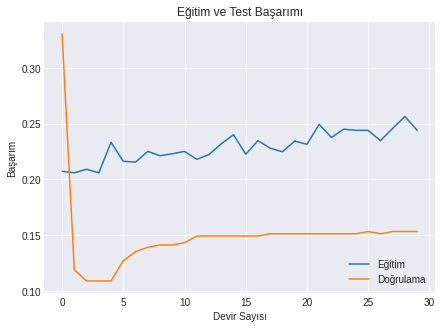

In [ ]:
plot_acc_loss_tr(history)

#### **Metrics Results**

In [ ]:
metric(X_test, y_test, model, model_name='InceptionResNet V2')



InceptionResNet V2  Model Accuracy Score:  0.15780445969125215


InceptionResNet V2  Model Balanced Accuracy Score: 0.16203128565502448 


InceptionResNet V2  Model F1 Score: 0.15780445969125215 


InceptionResNet V2  Model Precision Score: 0.15780445969125215 


InceptionResNet V2  Model Cohen Kappa Score: -0.2593676171034629 


InceptionResNet V2  Model Recall Score: 0.15780445969125215 


In [ ]:
model.evaluate(X_test, y_test)

19/19 [==============================] - 2s 99ms/step - loss: 1.7723 - acc: 0.1578


[1.772346019744873, 0.1578044593334198]

#### **Confusion Matrix**

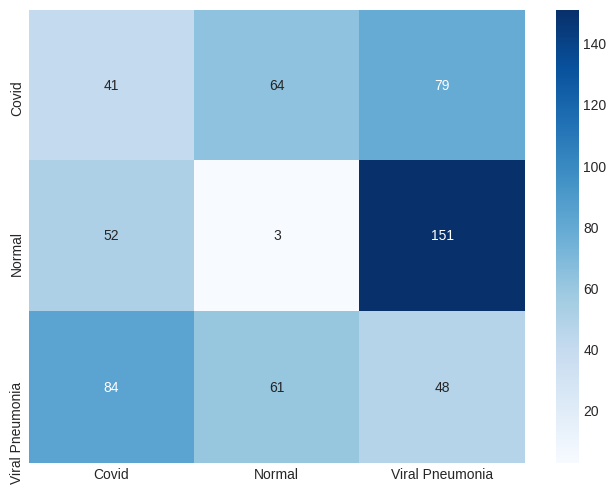

In [ ]:
cm_eng(X_test, y_test, model)

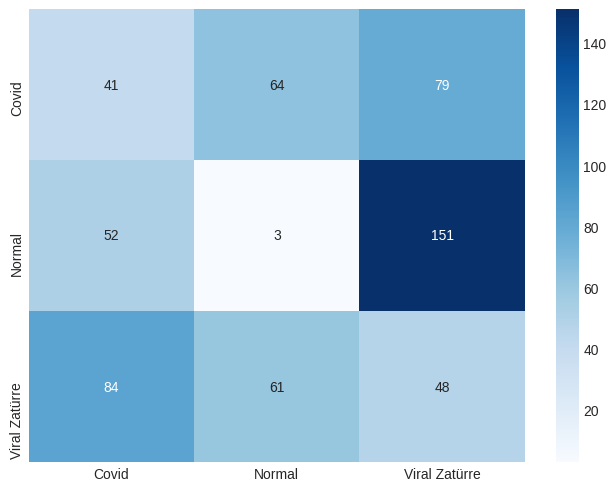

In [ ]:
cm_tr(X_test, y_test, model)

#### **Roc Curve**

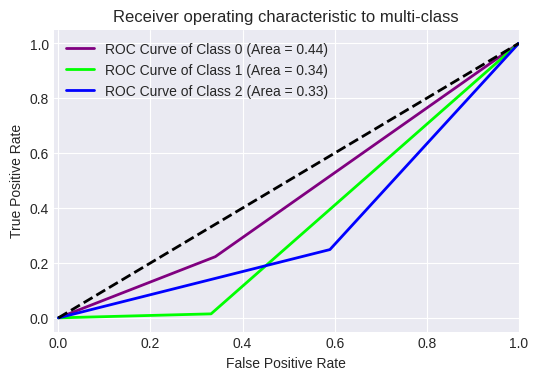

In [ ]:
plot_roc_curve_eng(X_test, y_test, model)

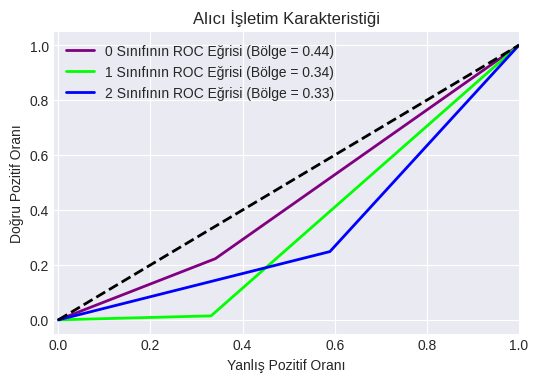

In [ ]:
plot_roc_curve_tr(X_test, y_test, model)

## **DenseNet169**

In [ ]:
densenet169 = DenseNet169(include_top=False, weights='imagenet', input_shape=(224, 224, 3))
densenet169.trainable=False

In [ ]:
inputs = tensorflow.keras.Input(shape=(224, 224, 3))
x = densenet169(inputs, training = True)

avg = GlobalAveragePooling2D()(x)

flat = Flatten()(avg)

batch = BatchNormalization()(flat)
drop = Dropout(0.25)(batch)
dense = Dense(512, activation='relu')(drop)
batch_2 = BatchNormalization()(dense)
drop_2 = Dropout(0.5)(batch_2)
outputs = tensorflow.keras.layers.Dense(3, activation=softmax)(drop_2)
model = tensorflow.keras.Model(inputs, outputs)
model.compile(optimizer=optimizer, loss=SparseCategoricalCrossentropy(), metrics='acc')
model.summary()

Model: "model_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_14 (InputLayer)        [(None, 224, 224, 3)]     0         
_________________________________________________________________
densenet169 (Functional)     (None, 7, 7, 1664)        12642880  
_________________________________________________________________
global_average_pooling2d_6 ( (None, 1664)              0         
_________________________________________________________________
flatten_6 (Flatten)          (None, 1664)              0         
_________________________________________________________________
batch_normalization_418 (Bat (None, 1664)              6656      
_________________________________________________________________
dropout_12 (Dropout)         (None, 1664)              0         
_________________________________________________________________
dense_12 (Dense)             (None, 512)               8524

#### **Train**

In [ ]:
callback_list = [
                 ReduceLROnPlateau(monitor="val_loss", factor = 0.1, patience=5),
                 CSVLogger('densenet_169.csv', append=True, separator=';'),
                 ModelCheckpoint(filepath='densenet_169.h5', monitor='val_loss', mode='min',verbose=1, save_best_only=True)
]

history = model.fit(X_train, y_train,
                    epochs=epochs,
                    validation_split=.15,
                    batch_size=batch_size, 
                    callbacks=callback_list)

Epoch 1/30
44/44 [==============================] - 15s 179ms/step - loss: 1.8742 - acc: 0.3783 - val_loss: 1.7489 - val_acc: 0.2883

Epoch 00001: val_loss improved from inf to 1.74890, saving model to densenet_169.h5
Epoch 2/30
44/44 [==============================] - 6s 134ms/step - loss: 1.8527 - acc: 0.3665 - val_loss: 1.4993 - val_acc: 0.2944

Epoch 00002: val_loss improved from 1.74890 to 1.49928, saving model to densenet_169.h5
Epoch 3/30
44/44 [==============================] - 6s 133ms/step - loss: 1.9263 - acc: 0.3508 - val_loss: 1.4209 - val_acc: 0.3528

Epoch 00003: val_loss improved from 1.49928 to 1.42092, saving model to densenet_169.h5
Epoch 4/30
44/44 [==============================] - 6s 134ms/step - loss: 1.8717 - acc: 0.3649 - val_loss: 1.4096 - val_acc: 0.3831

Epoch 00004: val_loss improved from 1.42092 to 1.40960, saving model to densenet_169.h5
Epoch 5/30
44/44 [==============================] - 6s 133ms/step - loss: 1.9175 - acc: 0.3509 - val_loss: 1.4184 - val

#### **Plot Acc - Loss**

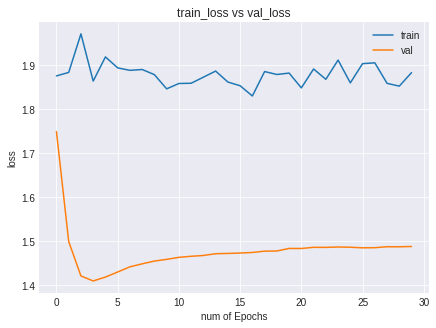

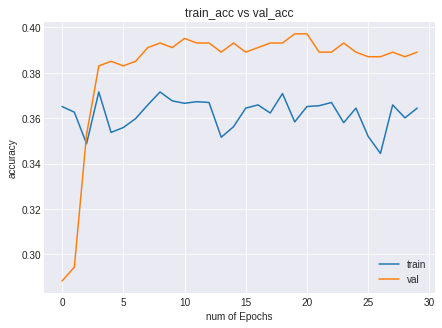

In [ ]:
plot_acc_loss_eng(history)

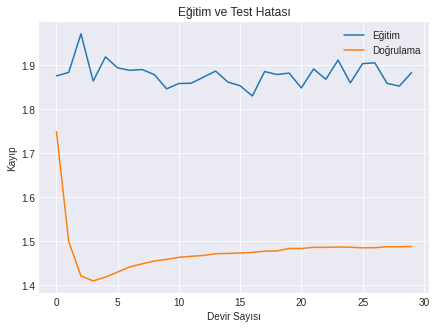

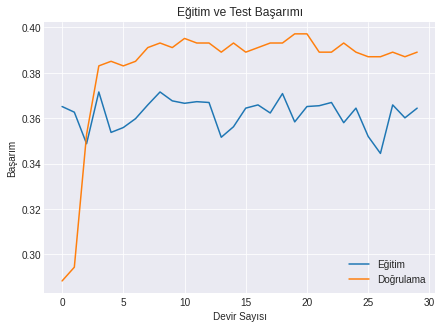

In [ ]:
plot_acc_loss_tr(history)

#### **Metrics Results**

In [ ]:
metric(X_test, y_test, model, model_name='DenseNet 169')



DenseNet 169  Model Accuracy Score:  0.40823327615780447


DenseNet 169  Model Balanced Accuracy Score: 0.40941673574400483 


DenseNet 169  Model F1 Score: 0.4082332761578044 


DenseNet 169  Model Precision Score: 0.40823327615780447 


DenseNet 169  Model Cohen Kappa Score: 0.11090335242945049 


DenseNet 169  Model Recall Score: 0.40823327615780447 


In [ ]:
model.evaluate(X_test, y_test)

19/19 [==============================] - 1s 61ms/step - loss: 1.3877 - acc: 0.4082


[1.387665033340454, 0.40823328495025635]

#### **Confusion Matrix**

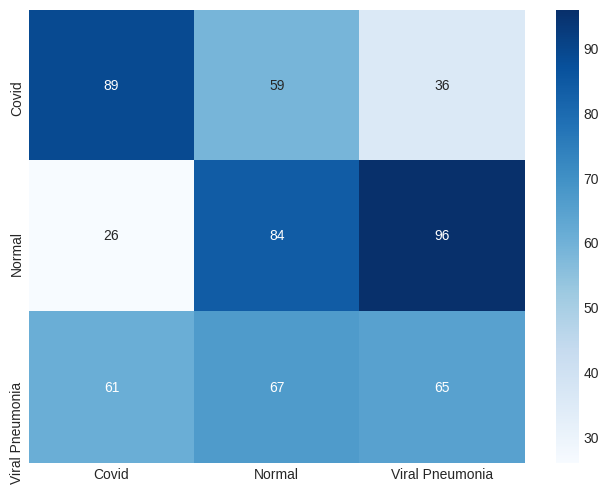

In [ ]:
cm_eng(X_test, y_test, model)

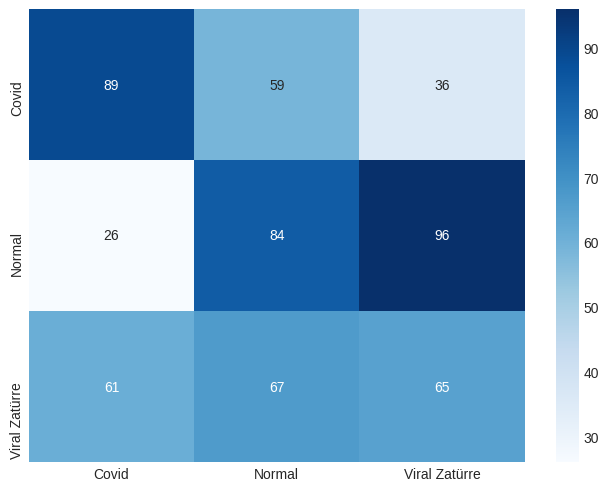

In [ ]:
cm_tr(X_test, y_test, model)

#### **Roc Curve**

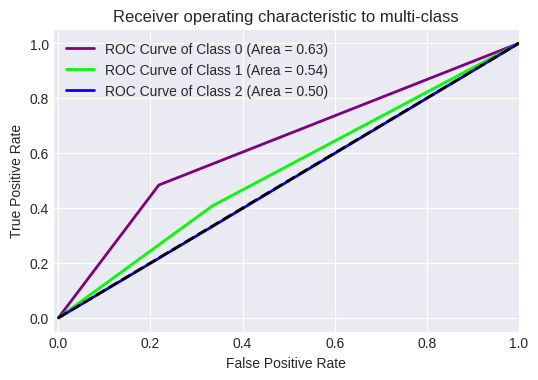

In [ ]:
plot_roc_curve_eng(X_test, y_test, model)

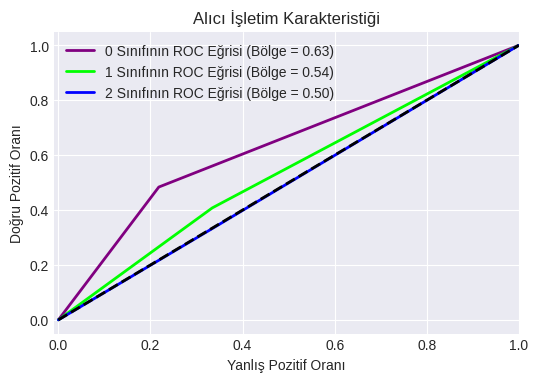

In [ ]:
plot_roc_curve_tr(X_test, y_test, model)

## **VGG19**

In [ ]:
vgg19 = VGG19(include_top=False, weights='imagenet', input_shape=(224, 224, 3))
vgg19.trainable = False

In [ ]:
inputs = tensorflow.keras.Input(shape=(224, 224, 3))
x = vgg19(inputs, training = True)

avg = GlobalAveragePooling2D()(x)

flat = Flatten()(avg)

batch = BatchNormalization()(flat)
drop = Dropout(0.25)(batch)
dense = Dense(512, activation='relu')(drop)
batch_2 = BatchNormalization()(dense)
drop_2 = Dropout(0.5)(batch_2)
outputs = tensorflow.keras.layers.Dense(3, activation=softmax)(drop_2)
model = tensorflow.keras.Model(inputs, outputs)
model.compile(optimizer=optimizer, loss=SparseCategoricalCrossentropy(), metrics='acc')
model.summary()

Model: "model_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_16 (InputLayer)        [(None, 224, 224, 3)]     0         
_________________________________________________________________
vgg19 (Functional)           (None, 7, 7, 512)         20024384  
_________________________________________________________________
global_average_pooling2d_7 ( (None, 512)               0         
_________________________________________________________________
flatten_7 (Flatten)          (None, 512)               0         
_________________________________________________________________
batch_normalization_420 (Bat (None, 512)               2048      
_________________________________________________________________
dropout_14 (Dropout)         (None, 512)               0         
_________________________________________________________________
dense_14 (Dense)             (None, 512)               2626

#### **Train**

In [ ]:
callback_list = [
                 ReduceLROnPlateau(monitor="val_loss", factor = 0.1, patience=5),
                 CSVLogger('vgg19.csv', append=True, separator=';'),
                 ModelCheckpoint(filepath='vgg19.h5', monitor='val_loss',mode='min',verbose=1,save_best_only=True)
]
history = model.fit(X_train, y_train,
                    epochs=epochs,
                    validation_split=.15,
                    batch_size=batch_size, 
                    callbacks=callback_list)

Epoch 1/30
44/44 [==============================] - 8s 161ms/step - loss: 1.8114 - acc: 0.3644 - val_loss: 1.5441 - val_acc: 0.3246

Epoch 00001: val_loss improved from inf to 1.54410, saving model to vgg19.h5
Epoch 2/30
44/44 [==============================] - 7s 156ms/step - loss: 1.8452 - acc: 0.3781 - val_loss: 1.3751 - val_acc: 0.3468

Epoch 00002: val_loss improved from 1.54410 to 1.37505, saving model to vgg19.h5
Epoch 3/30
44/44 [==============================] - 7s 156ms/step - loss: 1.8348 - acc: 0.3495 - val_loss: 1.3037 - val_acc: 0.3548

Epoch 00003: val_loss improved from 1.37505 to 1.30372, saving model to vgg19.h5
Epoch 4/30
44/44 [==============================] - 7s 157ms/step - loss: 1.8351 - acc: 0.3580 - val_loss: 1.2744 - val_acc: 0.3911

Epoch 00004: val_loss improved from 1.30372 to 1.27437, saving model to vgg19.h5
Epoch 5/30
44/44 [==============================] - 7s 156ms/step - loss: 1.8091 - acc: 0.3813 - val_loss: 1.2673 - val_acc: 0.3952

Epoch 00005: va

#### **Plot Acc - Loss**

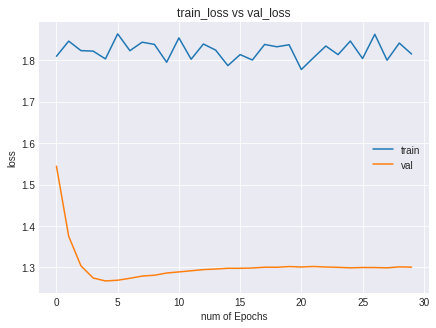

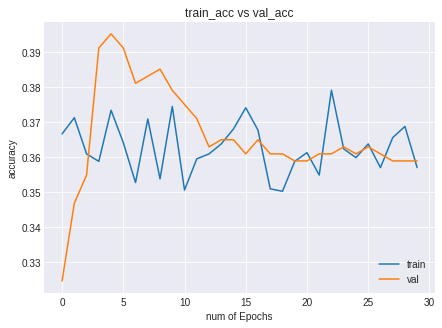

In [ ]:
plot_acc_loss_eng(history)

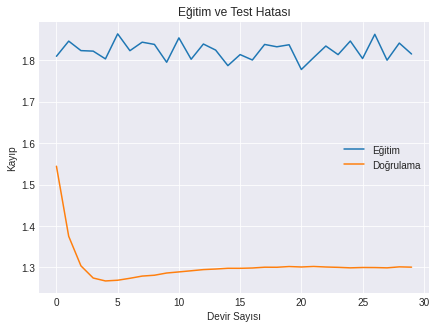

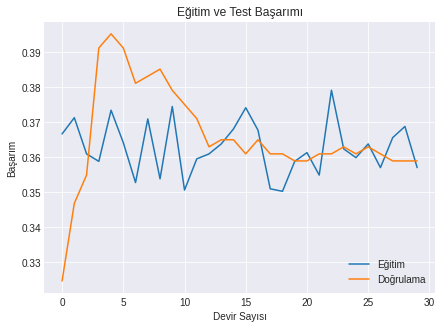

In [ ]:
plot_acc_loss_tr(history)

#### **Metrics Results**

In [ ]:
metric(X_test, y_test, model, model_name='VGG19')



VGG19  Model Accuracy Score:  0.38250428816466553


VGG19  Model Balanced Accuracy Score: 0.38524294809685555 


VGG19  Model F1 Score: 0.38250428816466553 


VGG19  Model Precision Score: 0.38250428816466553 


VGG19  Model Cohen Kappa Score: 0.07485200188661778 


VGG19  Model Recall Score: 0.38250428816466553 


In [ ]:
model.evaluate(X_test, y_test)

19/19 [==============================] - 1s 68ms/step - loss: 1.4228 - acc: 0.3825


[1.4228330850601196, 0.38250428438186646]

#### **Confusion Matrix**

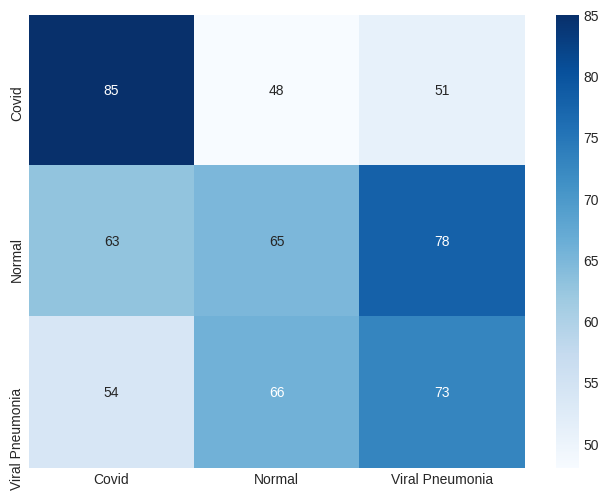

In [ ]:
cm_eng(X_test, y_test, model)

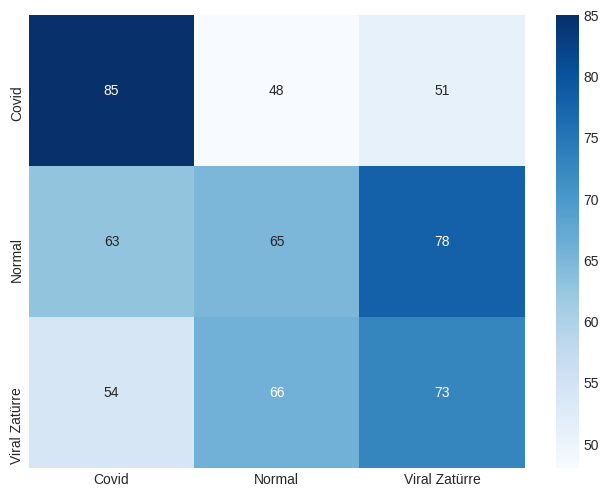

In [ ]:
cm_tr(X_test, y_test, model)

#### **Roc Curve**

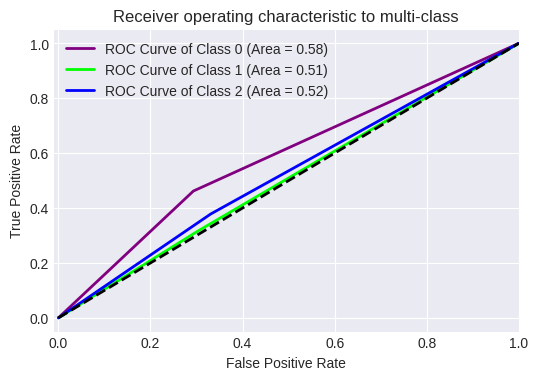

In [ ]:
plot_roc_curve_eng(X_test, y_test, model)

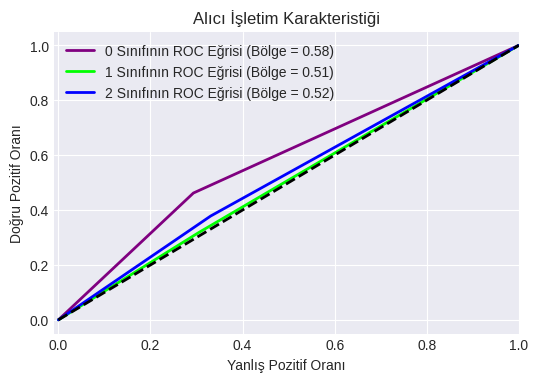

In [ ]:
plot_roc_curve_tr(X_test, y_test, model)